## Part A: Loading/Preprocessing Rotten Tomatoes Data

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Read in the data
df=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/rotten-tomatoes-analysis/main/data/rotten_tomatoes_movies.csv")
print(df.shape)

(17712, 22)


In [2]:
del df['rotten_tomatoes_link'], df['tomatometer_top_critics_count'], df['tomatometer_fresh_critics_count'], df['tomatometer_rotten_critics_count']

In [3]:
#Create new features
df[['og_year','og_month','og_day']] = df['original_release_date'].str.split('-',expand=True)
df[['str_year','str_month','str_day']] = df['streaming_release_date'].str.split('-',expand=True)
df['num_actors'] = df['actors'].str.count(',')+1
df['num_actors_group'] = pd.cut(df['num_actors'],
                      bins=[0, 5, 10, 25, 100, float('Inf')],
                      labels=['0-10', '10-25', '25-50','50-100','100+'])

In [4]:
df = df[(df['og_year'].notna()) & (df['str_year'].notna())]
df.shape

(16305, 26)

In [5]:
#Convert time features to integers
df['og_year'] = df['og_year'].astype(int)
df['str_year'] = df['str_year'].astype(int)

df['og_month'] = df['og_month'].astype(int)
df['str_month'] = df['str_month'].astype(int)

df['og_day'] = df['og_day'].astype(int)
df['str_day'] = df['str_day'].astype(int)

In [6]:
from nltk.tokenize import RegexpTokenizer
#!pip install contractions
import contractions
import re

def punct(text):
    token=RegexpTokenizer(r'\w+')#regex
    text = token.tokenize(text)
    text= " ".join(text)
    return text 

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_digits(text):
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def lemmatize(text):
    lemmed = contractions.fix(str(text))
    return lemmed


In [7]:
#Apply standardizing functions to synopsis and critic text
from nltk.corpus import stopwords

stop = stopwords.words('english')

#0.) Convert everything to string
df['cleaned_movie_info'] = df['movie_info'].astype(str)
df['cleaned_critics_consensus'] = df['critics_consensus'].astype(str)

#1.) Lowercase
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].str.lower()
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].str.lower()

#2.) Remove punctuation
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = punct)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = punct)

#3.) Remove non alpha-numeric characters
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_special_characters)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_special_characters)

#4.) Remove digits
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = remove_digits)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = remove_digits)

#5.) Lemmatize words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(func = lemmatize)
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(func = lemmatize)

#6. Remove stop words
df.loc[:,'cleaned_movie_info'] = df['cleaned_movie_info'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.loc[:,'cleaned_critics_consensus'] = df['cleaned_critics_consensus'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [8]:
#Set up VADER score to get labels for doing classification later
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df['synposis_scores_unpack'] = df['cleaned_movie_info'].map(lambda x: sia.polarity_scores(x))
df['critic_scores_unpack'] = df['cleaned_critics_consensus'].map(lambda x: sia.polarity_scores(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jonzimmerman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
df['synopsis_sentiment_score']  = df['synposis_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['synopsis_sentiment_class'] = df['synopsis_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df['critic_sentiment_score']  = df['critic_scores_unpack'].apply(lambda score_dict: score_dict['compound'])
df['critic_sentiment_class'] = df['critic_sentiment_score'].apply(lambda x: 1 if x >=0 else 0)
df.head(2)

,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,...,num_actors,num_actors_group,cleaned_movie_info,cleaned_critics_consensus,synposis_scores_unpack,critic_scores_unpack,synopsis_sentiment_score,synopsis_sentiment_class,critic_sentiment_score,critic_sentiment_class
0,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,...,87.0,50-100,always trouble prone life teenager percy jacks...,though may seem like another harry potter knoc...,"{'neg': 0.215, 'neu': 0.55, 'pos': 0.235, 'com...","{'neg': 0.0, 'neu': 0.507, 'pos': 0.493, 'comp...",-0.2023,0,0.9274,1
1,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2012-09-04,...,8.0,10-25,kate catherine keener husband alex oliver plat...,nicole holofcener newest might seem slight pla...,"{'neg': 0.089, 'neu': 0.789, 'pos': 0.121, 'co...","{'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...",0.2023,1,0.3612,1


## Part B: Referencing Kaggle
https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide

In [10]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['original_release_date'], format = '%Y/%m/%d')

## Part B1: Data Viz

In [11]:
#Filter data down a bit
filter_df = df[df['original_release_date']>='2000-01-01']
filter_df = filter_df[['date','critic_sentiment_score','synopsis_sentiment_score','tomatometer_rating','audience_rating']]
filter_df.head()

,date,critic_sentiment_score,synopsis_sentiment_score,tomatometer_rating,audience_rating
0,2010-02-12,0.9274,-0.2023,49.0,53.0
1,2010-04-30,0.3612,0.2023,87.0,64.0
5,2008-03-07,0.5106,0.8860,8.0,37.0
8,2002-09-27,0.0000,0.8658,20.0,87.0
10,2002-01-19,0.0000,-0.8617,80.0,66.0


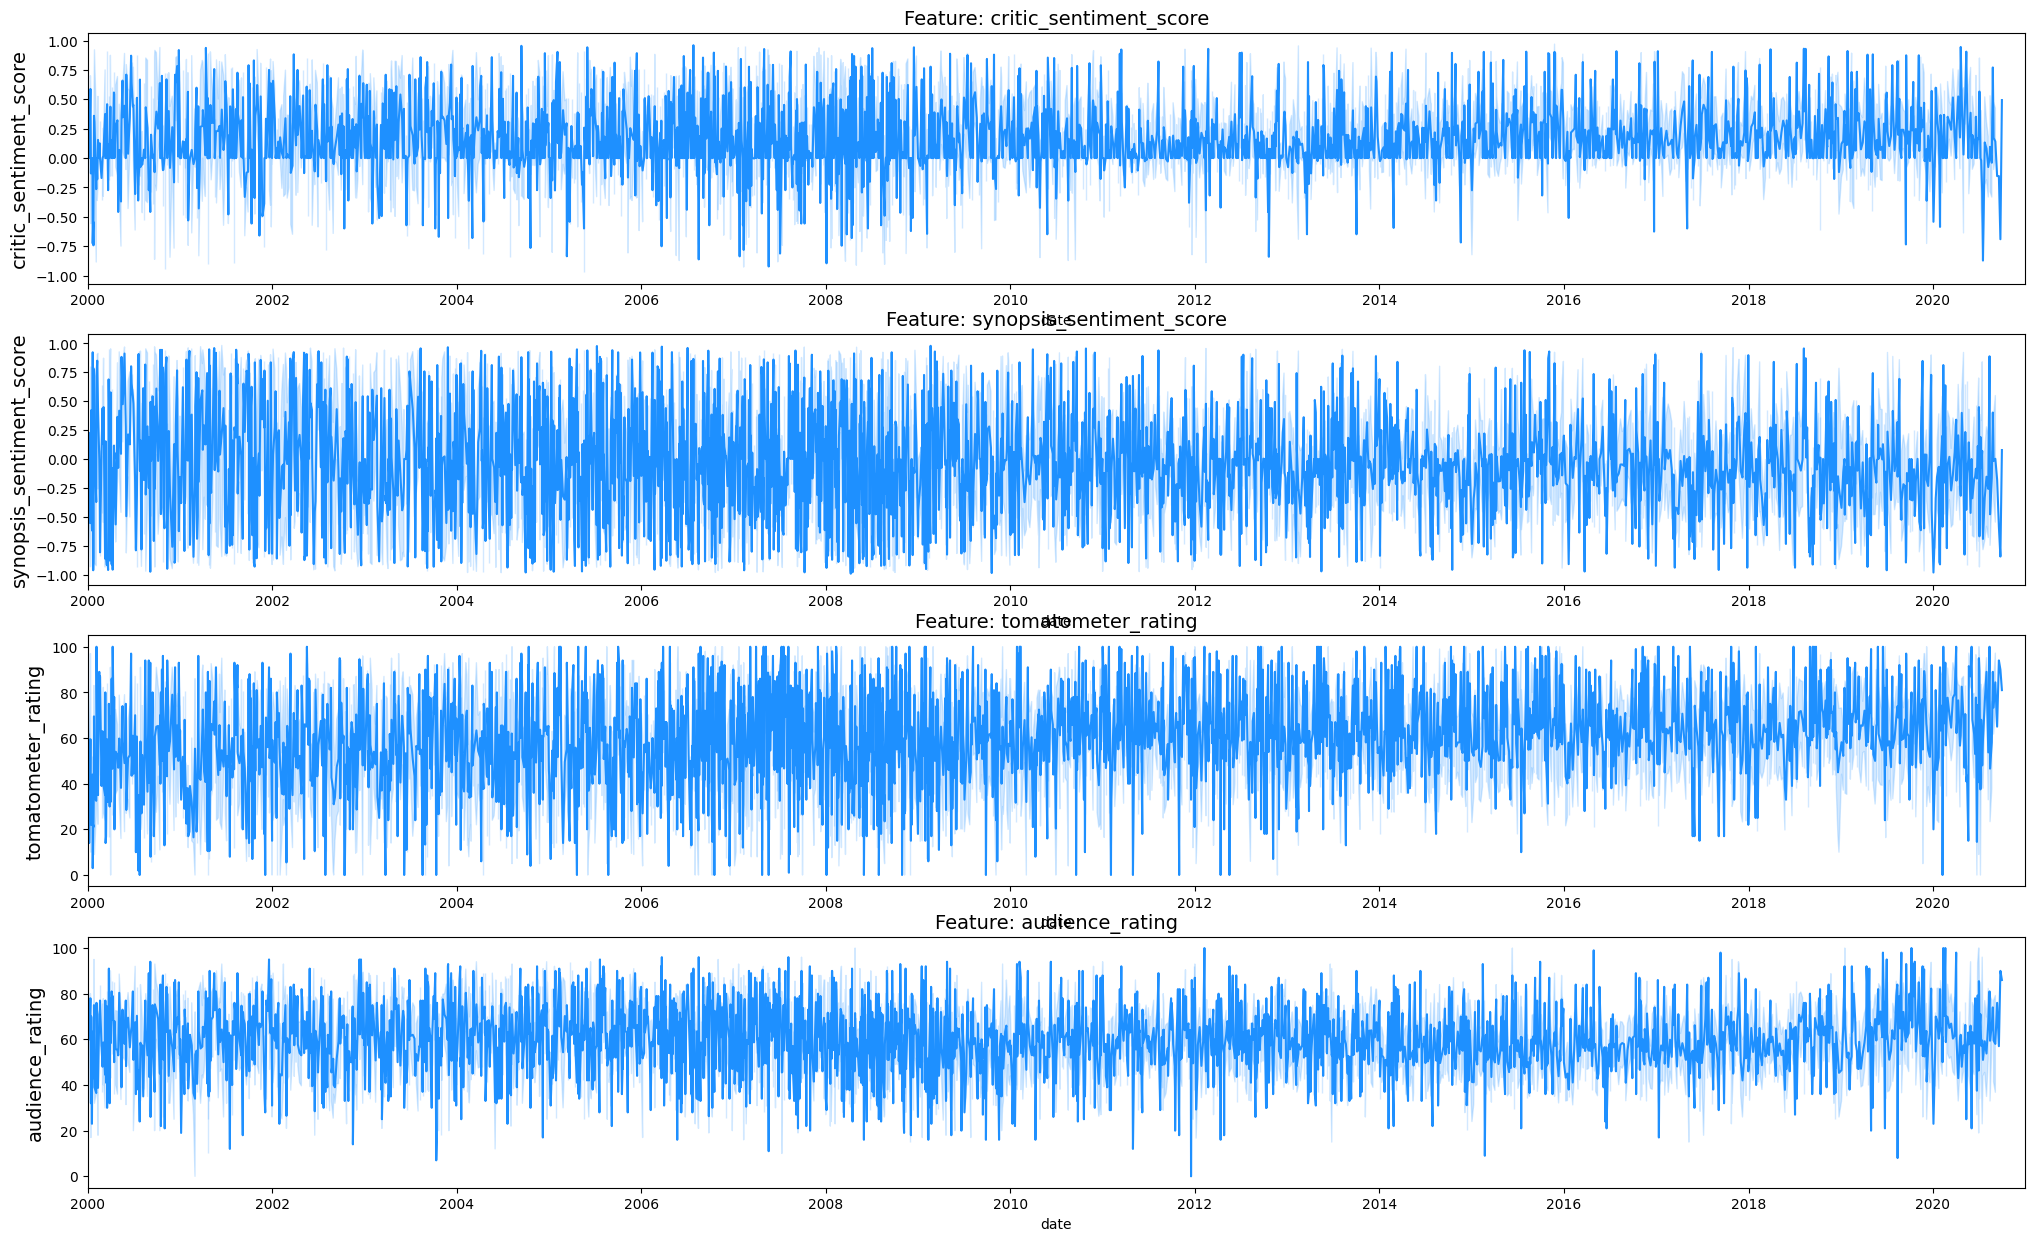

In [12]:
# To compelte the data, as naive method, we will use ffill
import seaborn as sns
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(25, 15))

for i, column in enumerate(filter_df.drop('date', axis=1).columns):
    sns.lineplot(x=filter_df['date'], y=filter_df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2000, 1, 1), date(2020, 12, 31)])

## Part B2: Data Preprocessing

Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [13]:
#Create new dataframe with one row per day
df = df.groupby('date').agg({
    'critic_sentiment_score': 'mean',
    'synopsis_sentiment_score':'mean',
    'tomatometer_rating':'mean',
    'audience_rating':'mean'
}).reset_index()
df.head()

,date,critic_sentiment_score,synopsis_sentiment_score,tomatometer_rating,audience_rating
0,1914-06-01,0.0000,-0.9477,96.0,69.0
1,1915-01-01,0.0000,0.7003,83.0,53.0
2,1915-03-03,-0.7037,-0.7964,93.0,56.0
3,1916-09-05,0.6597,-0.2732,97.0,77.0
4,1919-05-13,0.1531,-0.7096,95.0,71.0


In [14]:
df = df[df['date']>='2000-01-01']
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)
df[['date', 'delta']].head()

,date,delta
3231,2000-01-01,NaT
3232,2000-01-02,1 days
3233,2000-01-07,5 days
3234,2000-01-12,5 days
3235,2000-01-14,2 days


In [15]:
df['delta'].sum(), df['delta'].count()

(Timedelta('7578 days 00:00:00'), 2506)

In [16]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                         0
critic_sentiment_score       0
synopsis_sentiment_score     0
tomatometer_rating           1
audience_rating             21
dtype: int64

(14610.0, 18262.0)

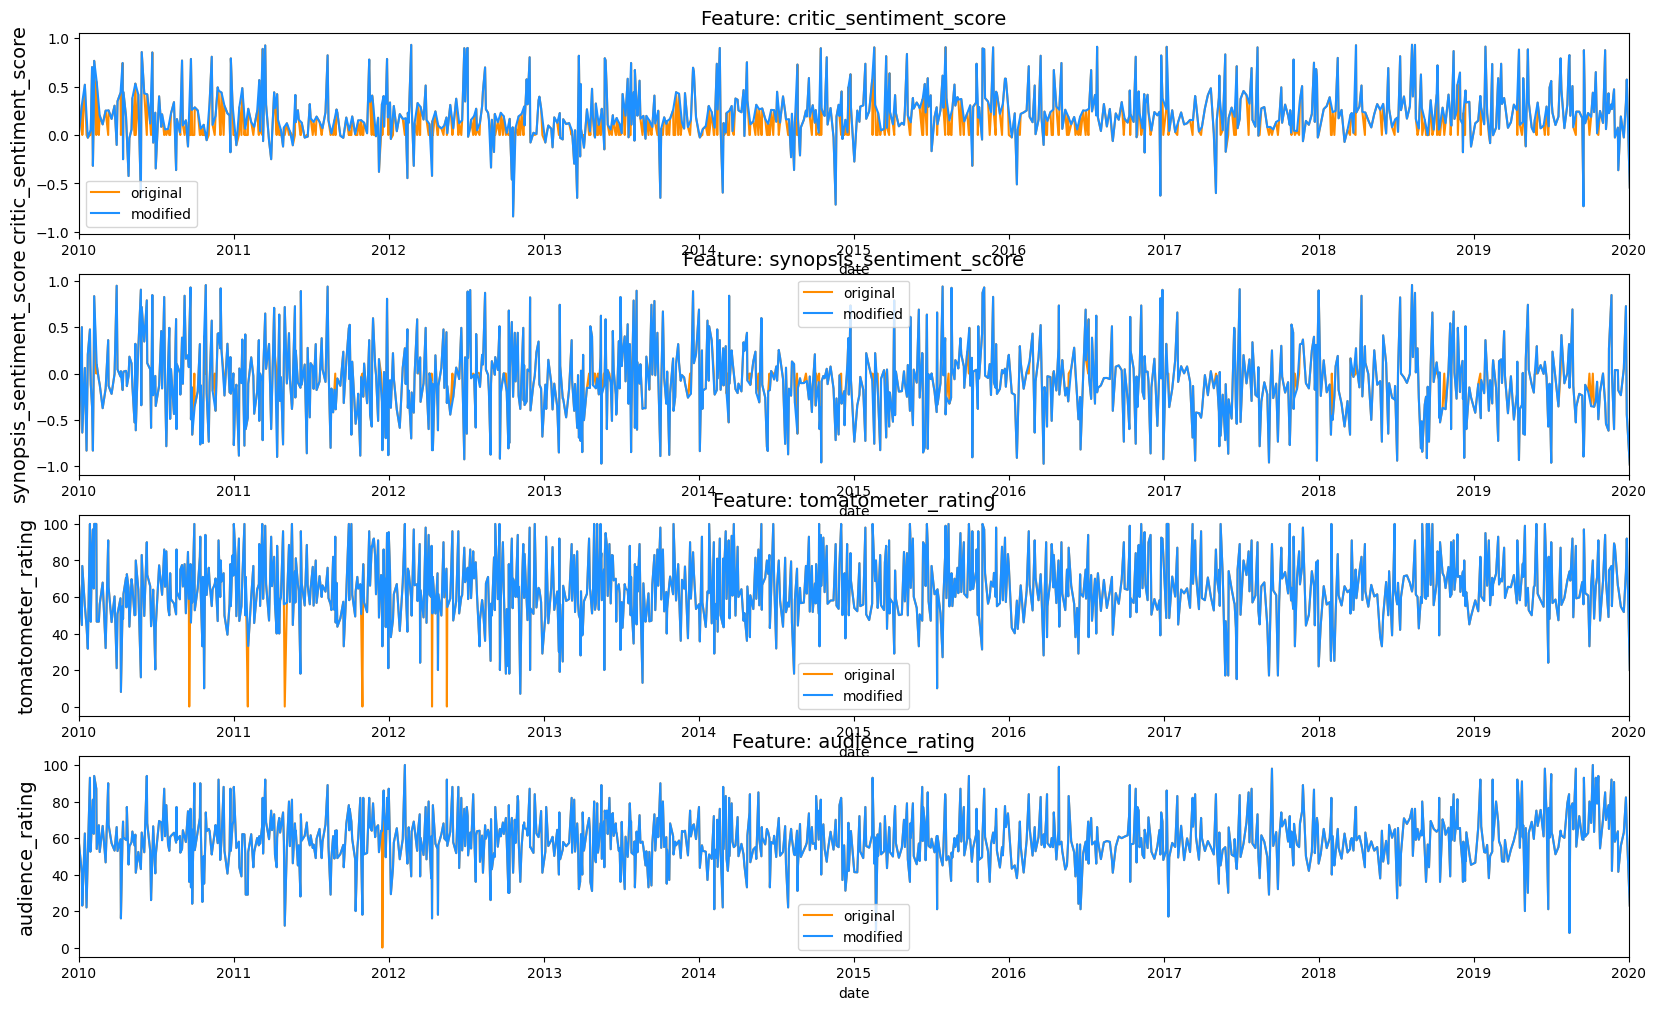

In [17]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 12))

old_critic = df['critic_sentiment_score'].copy()
df['critic_sentiment_score'] = df['critic_sentiment_score'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_critic, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: critic_sentiment_score', fontsize=14)
ax[0].set_ylabel(ylabel='critic_sentiment_score', fontsize=14)
ax[0].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

old_synop = df['synopsis_sentiment_score'].copy()
df['synopsis_sentiment_score'] = df['synopsis_sentiment_score'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_synop, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['synopsis_sentiment_score'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: synopsis_sentiment_score', fontsize=14)
ax[1].set_ylabel(ylabel='synopsis_sentiment_score', fontsize=14)
ax[1].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])


old_tomato = df['tomatometer_rating'].copy()
df['tomatometer_rating'] = df['tomatometer_rating'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_tomato, ax=ax[2], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['tomatometer_rating'].fillna(np.inf), ax=ax[2], color='dodgerblue', label='modified')
ax[2].set_title('Feature: tomatometer_rating', fontsize=14)
ax[2].set_ylabel(ylabel='tomatometer_rating', fontsize=14)
ax[2].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

old_audience = df['audience_rating'].copy()
df['audience_rating'] = df['audience_rating'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_audience, ax=ax[3], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['audience_rating'].fillna(np.inf), ax=ax[3], color='dodgerblue', label='modified')
ax[3].set_title('Feature: audience_rating', fontsize=14)
ax[3].set_ylabel(ylabel='audience_rating', fontsize=14)
ax[3].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])

So now we have to fix missing values. Lets take a look of these cases and explore what can we do with them.

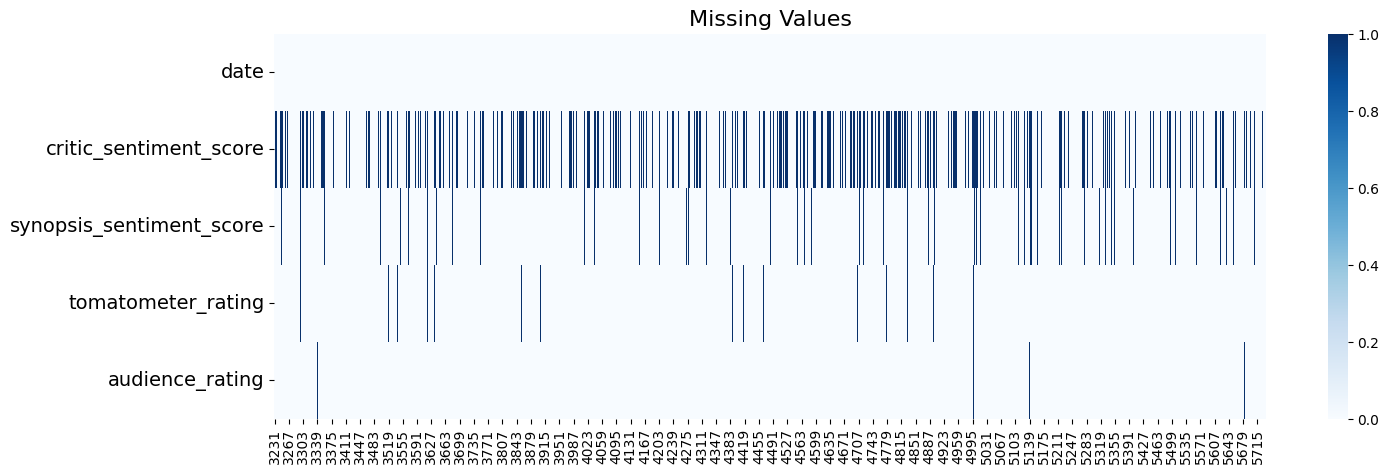

In [18]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

## Missing Values, how to handle
Option 1: Fill NaN with Outlier or Zero
In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

Option 2: Fill NaN with Mean Value
Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

Option 3: Fill NaN with Last Value with .ffill()
Filling NaNs with the last value could be bit better.

Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()
Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring value



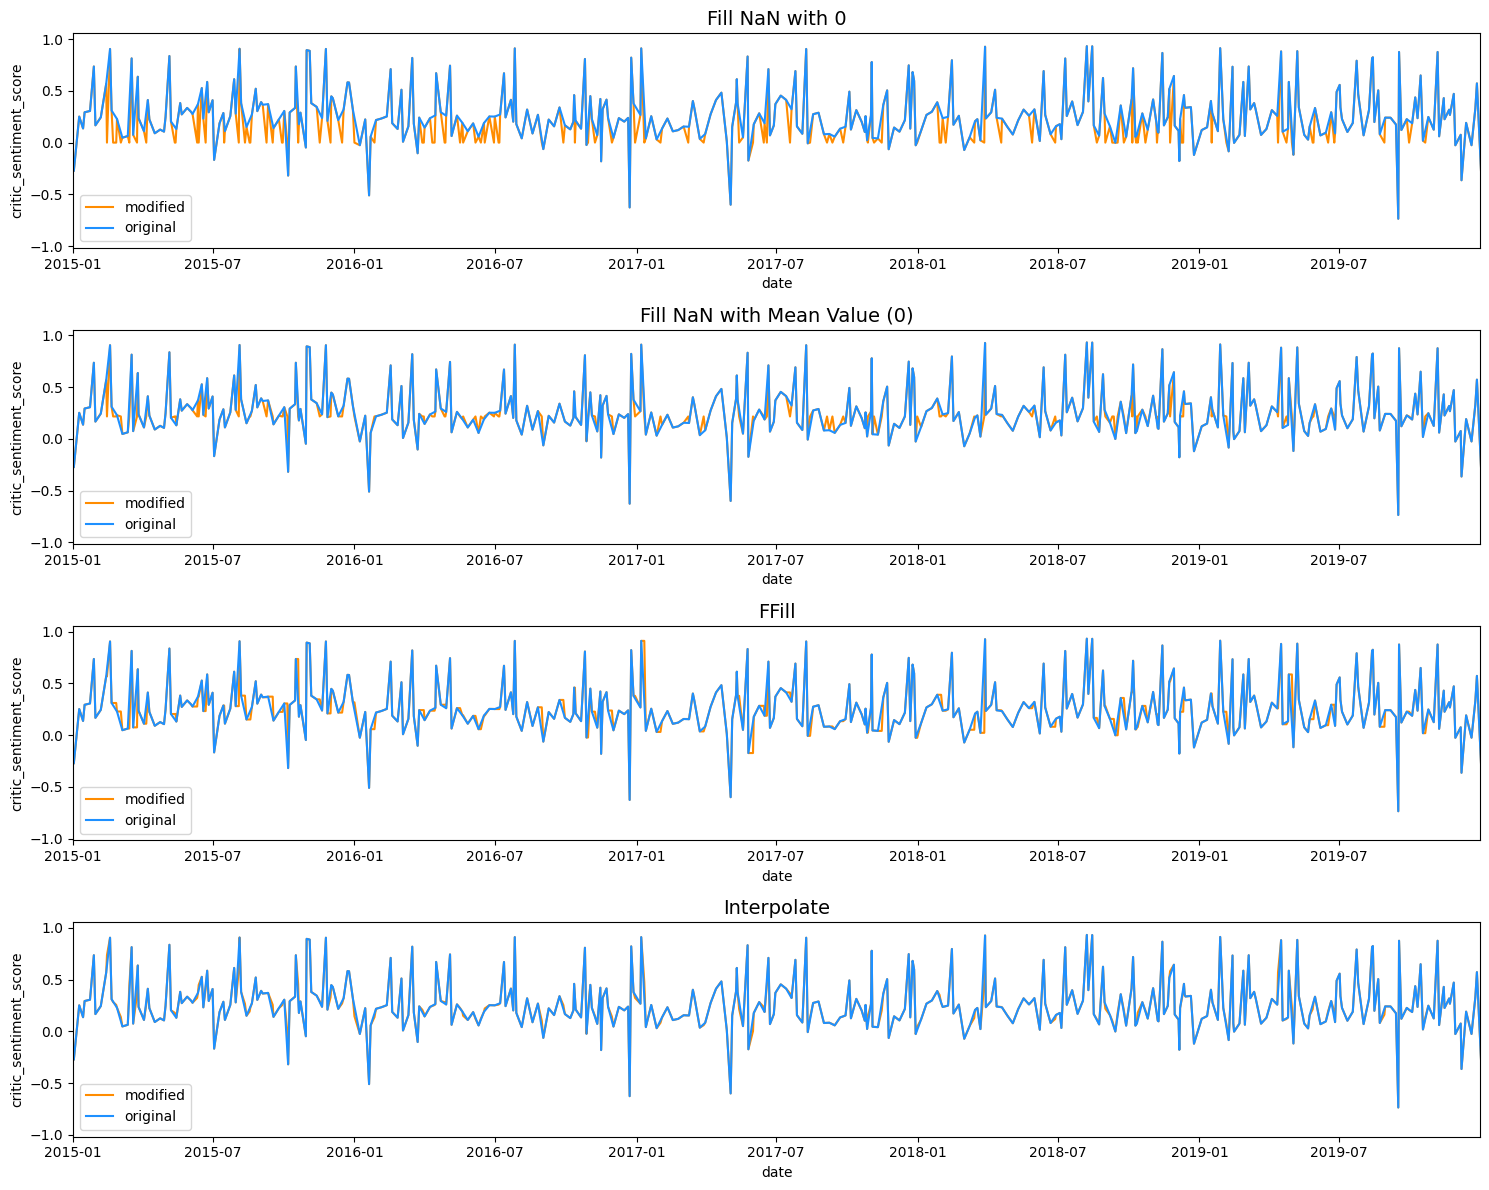

In [22]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)

mean_critc_sentiment = df['critic_sentiment_score'].mean()
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(mean_critc_sentiment), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_critc_sentiment:.0f})', fontsize=14)

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)

sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['critic_sentiment_score'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2015, 1, 1), date(2019, 12, 31)])
    
plt.tight_layout()
plt.show()


#### Fill NAs with 0 --> not best solution, but makes sense within context of our data, no movies released, so no critic scores, thus 0

In [24]:
df['critic_sentiment_score'] = df['critic_sentiment_score'].fillna(0)
df['synopsis_sentiment_score'] = df['synopsis_sentiment_score'].fillna(0)
df['tomatometer_rating'] = df['tomatometer_rating'].fillna(0)
df['audience_rating'] = df['audience_rating'].fillna(0)

df.isnull().sum()

date                        0
critic_sentiment_score      0
synopsis_sentiment_score    0
tomatometer_rating          0
audience_rating             0
dtype: int64

## Smoothing / Resampling

Resampling can provide additional information on the data. There are two types of resampling:

Upsampling is when the frequency of samples is increased (e.g. days to hours)

Downsampling is when the frequency of samples is decreased (e.g. days to weeks)
In this example, we will do some downsampling with the .resample() function (similar to groupby and aggregate as mean).

In [26]:
df.columns

Index(['date', 'critic_sentiment_score', 'synopsis_sentiment_score',
       'tomatometer_rating', 'audience_rating'],
      dtype='object')

TypeError: lineplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

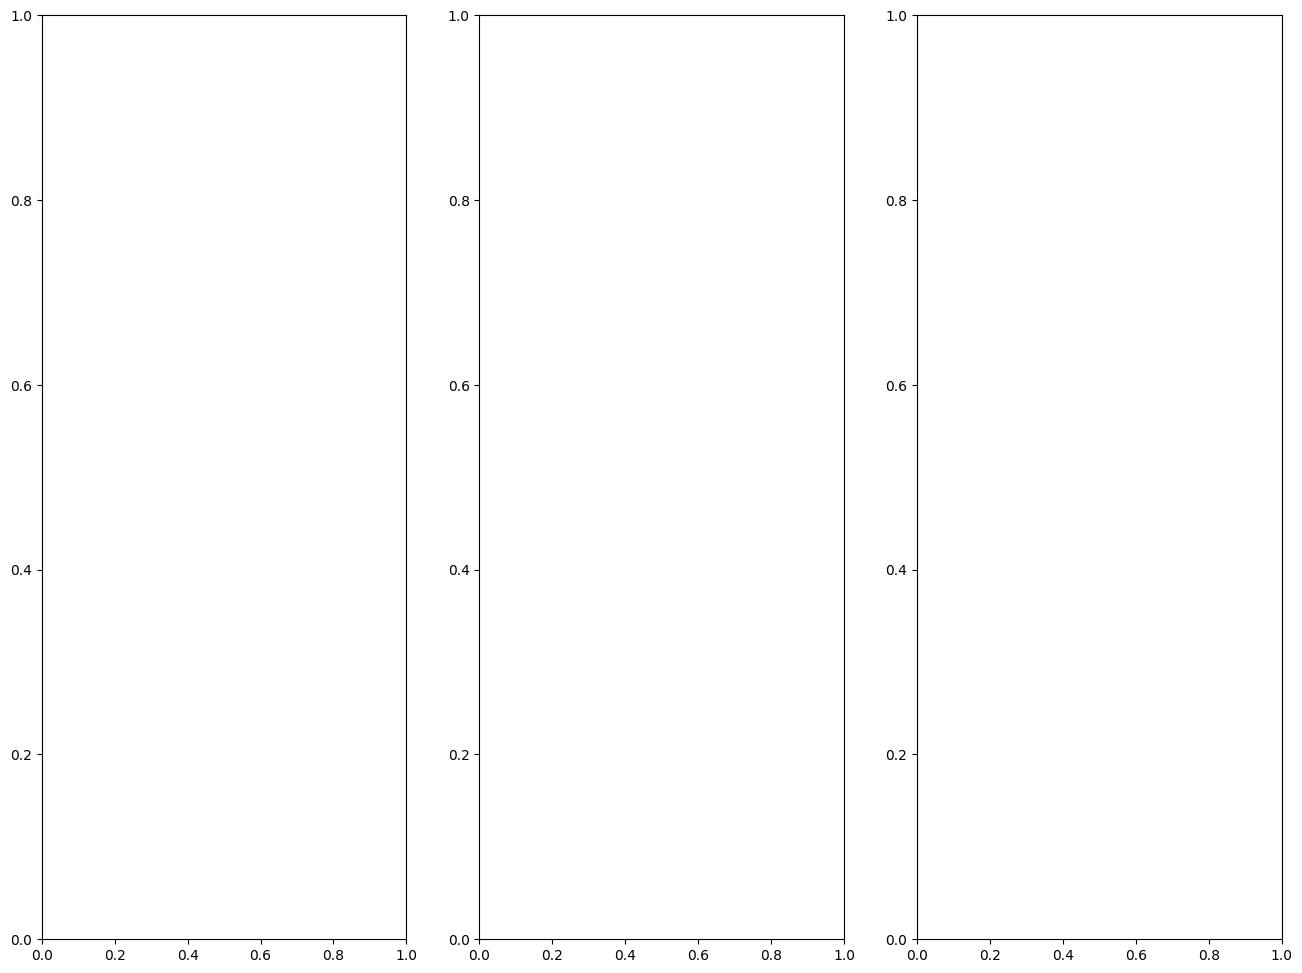

In [35]:
# fig, ax = plt.subplots(ncols=3, nrows=1, sharex=True, figsize=(16,12))

# sns.lineplot(df['date'], df['critic_sentiment_score'], color='dodgerblue', ax=ax[0, 0])
# ax[0, 0].set_title('Critic Sentiment Score', fontsize=14)

# resampled_df = df[['date','critic_sentiment_score']].resample('7D', on='date').sum().reset_index(drop=False)
# sns.lineplot(resampled_df['date'], resampled_df['critic_sentiment_score'], color='dodgerblue', ax=ax[1, 0])
# ax[1, 0].set_title('Weekly Critic Sentiment Score', fontsize=14)

# resampled_df = df[['date','critic_sentiment_score']].resample('M', on='date').sum().reset_index(drop=False)
# sns.lineplot(resampled_df['date'], resampled_df['critic_sentiment_score'], color='dodgerblue', ax=ax[2, 0])
# ax[2, 0].set_title('Monthly Critic Sentiment Score', fontsize=14)

# for i in range(3):
#     ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# sns.lineplot(df['date'], df['synopsis_sentiment_score'], color='dodgerblue', ax=ax[0, 1])
# ax[0, 1].set_title('Daily Synopsis Sentiment Score', fontsize=14)

# resampled_df = df[['date','synopsis_sentiment_score']].resample('7D', on='date').mean().reset_index(drop=False)
# sns.lineplot(resampled_df['date'], resampled_df['synopsis_sentiment_score'], color='dodgerblue', ax=ax[1, 1])
# ax[1, 1].set_title('Weekly Synopsis Sentiment Score', fontsize=14)

# resampled_df = df[['date','synopsis_sentiment_score']].resample('M', on='date').mean().reset_index(drop=False)
# sns.lineplot(resampled_df['date'], resampled_df['synopsis_sentiment_score'], color='dodgerblue', ax=ax[2, 1])
# ax[2, 1].set_title('Monthly Synopsis Sentiment Score', fontsize=14)

# for i in range(3):
#     ax[i, 1].set_xlim([date(2010, 1, 1), date(2020, 1, 1)])
# plt.show()